In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from datetime import date
import holidays
from fbprophet import Prophet

Приложение - мобильная утилита для сканирования документов. Модель монетизации
подписочная, есть пробный период 7 дней с дальнейшим переходом в оплату 4.99 USD
в неделю. По ссылке ниже выгрузка с базы данных по оформлениям подписок и оплат.
Каждая строка представляет собой отдельное событие (либо оформление пробной
подписки, либо оплата после завершения пробного периода)

In [3]:
df = pd.read_excel('test case data analyst.xlsx')

1. Необходимо рассчитать текущий LTV юзера, используя когортный анализ
(cohorting event - оформление пробного периода, когорта представляет собой кол-во
возможных операций).

In [4]:
df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657


In [5]:
df.product_id.unique()

array(['1week_4.99_USD_subscription_7days_trial'], dtype=object)

In [6]:
df.quantity.unique()

array([1])

In [7]:
del df['product_id']
del df['quantity'] # удаляем столбцы, т.к. в них только один вид переменных

In [8]:
mindate = df.sort_values('purchase_date').drop_duplicates('user_id')

In [9]:
maxdate = df.sort_values('purchase_date',ascending = False).drop_duplicates('user_id')

In [10]:
mindate = mindate[['purchase_date','user_id']]

In [11]:
maxdate = maxdate[['purchase_date','user_id']]

In [12]:
mindate = mindate.rename(columns = {'purchase_date':'cohort_first'})
maxdate = maxdate.rename(columns = {'purchase_date':'cohort_last'})

In [13]:
df = df.merge(mindate,how = 'left', on = 'user_id')
df = df.merge(maxdate,how = 'left', on = 'user_id')

In [14]:
df_pay = df.query('is_trial_period == True')

In [15]:
df_pay['week_first'] = df_pay.cohort_first.dt.week
df_pay['week_last'] = df_pay.cohort_last.dt.week

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [16]:
df_pay['total_week'] = (df_pay.week_last - df_pay.week_first)+1

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
df_pay['total_profit'] = 4.99 * df_pay.total_week

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
df_pay

,is_trial_period,purchase_date,user_id,cohort_first,cohort_last,week_first,week_last,total_week,total_profit
2601,True,2020-02-10,9429240,2020-02-10,2020-02-10,7,7,1,4.99
2602,True,2020-01-14,6629221,2020-01-14,2020-01-14,3,3,1,4.99
2603,True,2020-01-07,8428489,2020-01-07,2020-01-07,2,2,1,4.99
2604,True,2020-02-05,9294519,2020-02-05,2020-02-05,6,6,1,4.99
2605,True,2020-02-14,7611125,2020-02-14,2020-02-14,7,7,1,4.99
...,...,...,...,...,...,...,...,...,...
114195,True,2020-01-04,8291100,2020-01-04,2020-02-15,1,7,7,34.93
114196,True,2020-01-02,8236936,2020-01-02,2020-01-02,1,1,1,4.99
114197,True,2020-01-03,8247910,2020-01-03,2020-01-03,1,1,1,4.99
114198,True,2020-01-04,8294146,2020-01-04,2020-01-04,1,1,1,4.99


total_week в данном случае - наши когорты.


In [19]:
df_pay.total_week.unique()

array([1, 2, 6, 3, 4, 5, 7, 8])

In [20]:
cohort = df_pay.groupby('total_week',as_index = False)\
          .agg({'user_id':'count'})

In [21]:
cohort['total_profit'] = cohort.total_week * cohort.user_id * 4.99

In [22]:
cohort_test = cohort

In [23]:
cohort_test['CR'] = (cohort_test.user_id/df.user_id.count()).round(2)
cohort_test['ARPPU'] = (cohort.user_id/cohort.total_profit).round(2)
cohort_test['ARPU'] = cohort_test.CR * cohort_test.ARPPU
cohort_test['LTV'] = cohort_test.ARPU/cohort.total_week

In [24]:
cohort_test

,total_week,user_id,total_profit,CR,ARPPU,ARPU,LTV
0,1,43402,216575.98,0.38,0.20,0.0760,0.076000
1,2,6314,63013.72,0.06,0.10,0.0060,0.003000
2,3,3920,58682.40,0.03,0.07,0.0021,0.000700
3,4,2820,56287.20,0.02,0.05,0.0010,0.000250
4,5,2391,59655.45,0.02,0.04,0.0008,0.000160
5,6,2081,62305.14,0.02,0.03,0.0006,0.000100
6,7,1753,61232.29,0.02,0.03,0.0006,0.000086
7,8,327,13053.84,0.00,0.03,0.0000,0.000000


Благодаря когортному анализу мы можем сделать вывод что самая прибыльная когорта - юзеры, которые оплатили всего неделю, нежели постоянные клиенты.

2)Спрогнозировать количество пользователей.

In [27]:
df_m = df_pay.groupby('purchase_date',as_index = False)\
             .agg({'user_id':'count','total_profit':'sum'})
df = df.drop(index=[0])
df = df.drop(index=[50])

In [28]:
df_vr = df_m
del df_vr['total_profit']

In [29]:
df_vr = df_vr.rename(columns={'purchase_date':'ds','user_id':'y'})

In [30]:
df_vr.head(3)

,ds,y
0,2020-01-01,905
1,2020-01-02,1300
2,2020-01-03,1442


In [31]:
df_vr.shape

(51, 2)

In [32]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 30

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = df_vr[:-predictions]

In [33]:
m = Prophet()
m.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


In [34]:
# Предсказываем 30 дней
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

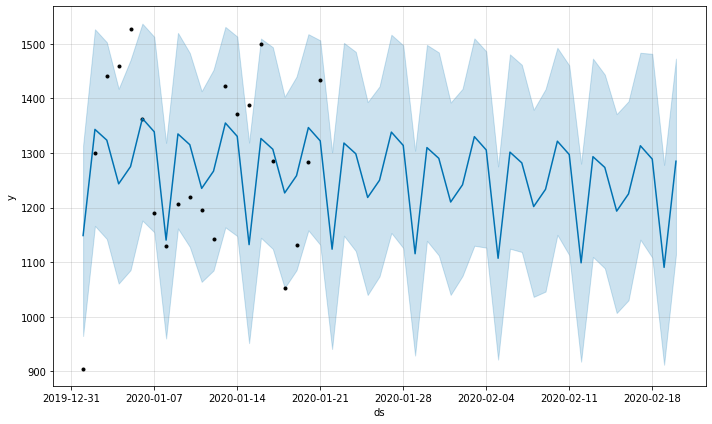

In [35]:
# Смотрим, что предсказалось
m.plot(forecast);

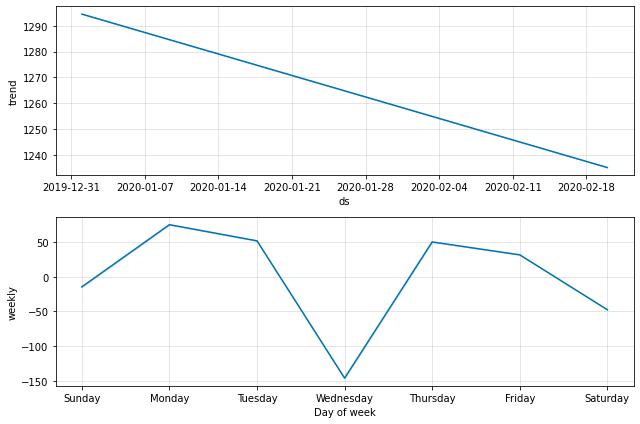

In [36]:
# Смотрим на сезонности
m.plot_components(forecast);

In [37]:
m.predict()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,1294.562735,972.265624,1323.527921,1294.562735,1294.562735,-145.760919,-145.760919,-145.760919,-145.760919,-145.760919,-145.760919,0.0,0.0,0.0,1148.801816
1,2020-01-02,1293.372063,1161.035571,1510.580904,1293.372063,1293.372063,49.985200,49.985200,49.985200,49.985200,49.985200,49.985200,0.0,0.0,0.0,1343.357263
2,2020-01-03,1292.181390,1149.139836,1513.985113,1292.181390,1292.181390,31.457198,31.457198,31.457198,31.457198,31.457198,31.457198,0.0,0.0,0.0,1323.638588
3,2020-01-04,1290.990718,1066.207793,1436.647251,1290.990718,1290.990718,-47.400640,-47.400640,-47.400640,-47.400640,-47.400640,-47.400640,0.0,0.0,0.0,1243.590077
4,2020-01-05,1289.800045,1117.646005,1466.975174,1289.800045,1289.800045,-14.621464,-14.621464,-14.621464,-14.621464,-14.621464,-14.621464,0.0,0.0,0.0,1275.178581
5,2020-01-06,1288.609373,1183.595507,1542.522759,1288.609373,1288.609373,74.784761,74.784761,74.784761,74.784761,74.784761,74.784761,0.0,0.0,0.0,1363.394134
6,2020-01-07,1287.418700,1165.365780,1528.991543,1287.418700,1287.418700,51.555864,51.555864,51.555864,51.555864,51.555864,51.555864,0.0,0.0,0.0,1338.974564
7,2020-01-08,1286.228027,952.111817,1313.820134,1286.228027,1286.228027,-145.760919,-145.760919,-145.760919,-145.760919,-145.760919,-145.760919,0.0,0.0,0.0,1140.467108
8,2020-01-09,1285.037355,1151.048431,1523.446841,1285.037355,1285.037355,49.985200,49.985200,49.985200,49.985200,49.985200,49.985200,0.0,0.0,0.0,1335.022555
9,2020-01-10,1283.846682,1139.498729,1500.185112,1283.846682,1283.846682,31.457198,31.457198,31.457198,31.457198,31.457198,31.457198,0.0,0.0,0.0,1315.303880
